In [12]:
# from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

In [13]:
url = "https://drive.usercontent.google.com/u/0/uc?id=1pDqazBinw3E3-1OyqzfACq5SrBqwYs_4&export=download"

HDMA = pd.read_csv(url)
HDMA.head()

/var/folders/2c/syyg1pks1tn35zqcqdf1629m0000gn/T/ipykernel_37223/446313229.py:3: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  HDMA = pd.read_csv(url)


,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,549300FGXN1K3HLB1R50,39580,NC,37183,3.718305e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,10600,27.27,110100,144.56,2355,2695,16
1,2022,549300FGXN1K3HLB1R50,39580,NC,37183,3.718305e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,6300,72.98,110100,83.71,1386,1917,19
2,2022,549300FGXN1K3HLB1R50,39580,NC,37183,3.718305e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,6300,72.98,110100,83.71,1386,1917,19
3,2022,549300FGXN1K3HLB1R50,39580,NC,37183,3.718305e+10,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,7613,62.12,110100,91.54,2041,2513,18
4,2022,549300FGXN1K3HLB1R50,39580,NC,37183,3.718305e+10,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,7746,74.35,110100,145.04,1981,2500,9


#### **These are all the variables we thought could provide some useful information.**
*We can eventually delete the next code.*

In [14]:
selected_columns = [
    # Bias Analysis
    'derived_race', 'derived_ethnicity', 'derived_sex', 'applicant_age', 'income', 'debt_to_income_ratio',
    'applicant_race-1', 'co-applicant_race-1', 'applicant_ethnicity-1', 'co-applicant_ethnicity-1',

    # Loan-Specific Variables
    'loan_amount', 'interest_rate', 'loan_to_value_ratio', 'loan_type', 'loan_purpose', 'lien_status',

    # Geographic Variable
    'census_tract',

    # Loan Decision Variables
    'action_taken', 'purchaser_type', 'preapproval', 'aus-1', 'denial_reason-1',

    # Bias & Fairness Analysis
    'rate_spread', 'hoepa_status', 'negative_amortization', 'interest_only_payment', 'balloon_payment',

    # Lender Bias
    'lei', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category'
]
# Filter dataset
missing_value_check = HDMA[selected_columns]

# Display summary of the cleaned dataset
print(missing_value_check.info())
missing_value_check.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76111 entries, 0 to 76110
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   derived_race               76111 non-null  object 
 1   derived_ethnicity          76111 non-null  object 
 2   derived_sex                76111 non-null  object 
 3   applicant_age              76111 non-null  object 
 4   income                     70594 non-null  float64
 5   debt_to_income_ratio       53332 non-null  object 
 6   applicant_race-1           76102 non-null  float64
 7   co-applicant_race-1        76109 non-null  float64
 8   applicant_ethnicity-1      76080 non-null  float64
 9   co-applicant_ethnicity-1   76103 non-null  float64
 10  loan_amount                76111 non-null  float64
 11  interest_rate              51174 non-null  object 
 12  loan_to_value_ratio        53005 non-null  object 
 13  loan_type                  76111 non-null  int

,derived_race,derived_ethnicity,derived_sex,applicant_age,income,debt_to_income_ratio,applicant_race-1,co-applicant_race-1,applicant_ethnicity-1,co-applicant_ethnicity-1,...,denial_reason-1,rate_spread,hoepa_status,negative_amortization,interest_only_payment,balloon_payment,lei,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category
0,Race Not Available,Ethnicity Not Available,Sex Not Available,35-44,81.0,49,6.0,8.0,3.0,5.0,...,10,0.977,2,2,2,2,549300FGXN1K3HLB1R50,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built
1,Black or African American,Not Hispanic or Latino,Female,45-54,94.0,40,3.0,8.0,2.0,5.0,...,10,0.463,2,2,2,2,549300FGXN1K3HLB1R50,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built
2,Asian,Not Hispanic or Latino,Joint,25-34,204.0,<20%,2.0,2.0,2.0,2.0,...,10,-0.18,2,2,2,2,549300FGXN1K3HLB1R50,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built
3,White,Hispanic or Latino,Male,45-54,195.0,<20%,5.0,8.0,1.0,5.0,...,10,4.392,2,2,2,2,549300FGXN1K3HLB1R50,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built
4,Race Not Available,Ethnicity Not Available,Sex Not Available,25-34,109.0,<20%,6.0,8.0,3.0,5.0,...,10,0.181,2,2,2,2,549300FGXN1K3HLB1R50,C,FHA:First Lien,Single Family (1-4 Units):Site-Built


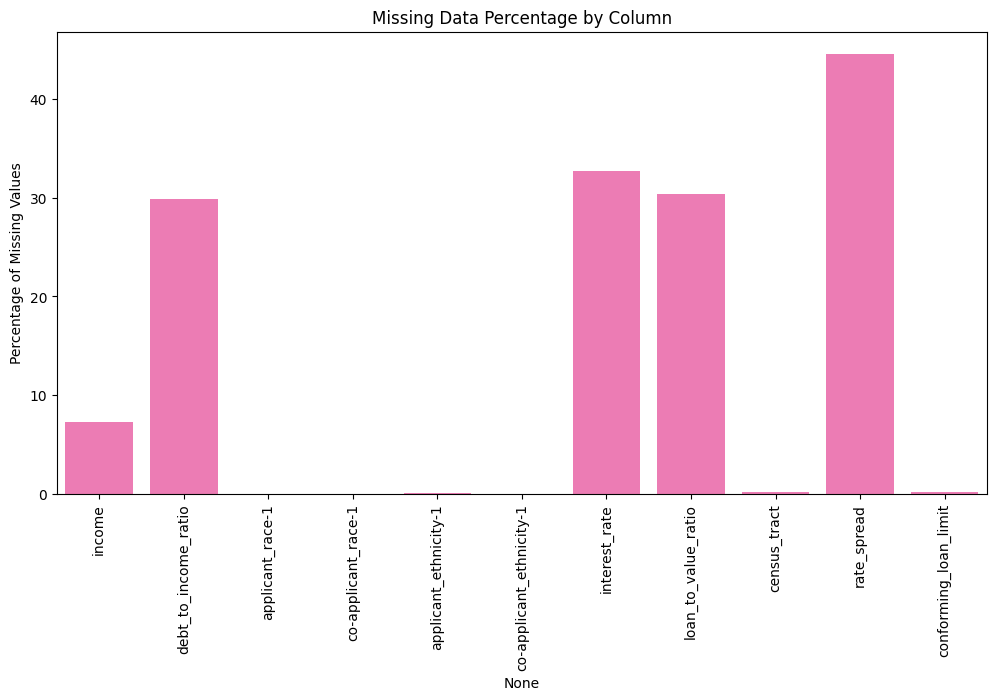

rate_spread                 44.605905
interest_rate               32.763989
loan_to_value_ratio         30.358292
debt_to_income_ratio        29.928657
income                       7.248624
conforming_loan_limit        0.193139
census_tract                 0.141898
applicant_ethnicity-1        0.040730
applicant_race-1             0.011825
co-applicant_ethnicity-1     0.010511
co-applicant_race-1          0.002628
dtype: float64


In [15]:
# Calculate missing values percentage for selected columns
missing_percentages = missing_value_check.isnull().mean() * 100

# Filter columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Plot missing values
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_percentages.index, y=missing_percentages.values, color="hotpink")
plt.xticks(rotation=90)
plt.ylabel("Percentage of Missing Values")
plt.title("Missing Data Percentage by Column")

# Show plot
plt.show()

# Display missing values in descending order
missing_percentages = missing_percentages.sort_values(ascending=False)

# Show the results
print(missing_percentages)

**There are too many missing values, so we have to clean the dataset**

# **Data Cleaning**

## **Drop Columns with >95% Missing Data.**
**Since there are a lot of missing values, we;**
1. Drop columns with 100% missing values.
2. Drop columns with more than 95% missing value.
3. Keep only the relevant columns necessary for our bias detection and fairness analysis.

In [16]:
# Drop Columns with High Missing Values

# Define columns to drop (100% missing and >95% missing)
columns_to_drop = [
    # 100% missing
    'applicant_ethnicity-4', 'applicant_ethnicity-5', 'co-applicant_ethnicity-5',
    'co-applicant_ethnicity-4', 'co-applicant_race-5', 'applicant_race-5',

    # >95% missing
    'co-applicant_race-4', 'co-applicant_ethnicity-3', 'denial_reason-4', 'applicant_race-4',
    'applicant_ethnicity-3', 'co-applicant_race-3', 'denial_reason-3', 'multifamily_affordable_units',
    'applicant_race-3', 'total_points_and_fees', 'aus-5', 'co-applicant_ethnicity-2', 'aus-4',
    'aus-3', 'aus-2', 'denial_reason-2', 'applicant_ethnicity-2', 'co-applicant_race-2', 'prepayment_penalty_term'
]

# Drop the identified columns (errors='ignore' ensures no error if a column is already missing)
HDMA = HDMA.drop(columns=columns_to_drop, errors='ignore')

print(f"✅Dropped {len(columns_to_drop)} columns with excessive missing data.")


✅Dropped 25 columns with excessive missing data.


## **Impute Key Loan/Financial Features (50-95% Missing).**

Certain loan and financial variables have a high percentage of missing values but are essential for creditworthiness assessment and loan approval decisions. Rather than removing these variables, an imputation strategy will be applied based on the nature of each variable.

| **Column**                     | **Missing %** | **Imputation Strategy**  |
|--------------------------------|--------------|--------------------------|
| lender_credits                 | 83.89%       | Fill with **"Unknown"** (to preserve missingness and avoid bias) |
| discount_points                | 77.90%       | Fill with **"Unknown"** (to preserve missingness and avoid bias) |
| intro_rate_period              | 69.82%       | Fill with **median** |
| co-applicant_age_above_62      | 63.60%       | Fill with **"Unknown"** (to preserve missingness and avoid bias) |
| total_loan_costs               | 53.95%       | Fill with **median** |
| origination_charges            | 53.70%       | Fill with **median** |

This imputation approach ensures that critical financial information is retained while minimizing bias in the dataset.


#### **Imputing Missing Values in co-applicant_age_above_62**

The variable *co-applicant_age_above_62* has a significant proportion of missing values. Among the known values, 85.73% are classified as "No," while 14.27% are classified as "Yes." **A mode-based imputation strategy would suggest filling missing values with "No," as it represents the majority.** However, this approach assumes that the distribution of missing values follows the observed data, which may introduce unintended bias by underrepresenting older co-applicants.

To ensure fairness and avoid reinforcing potential biases, the missing values will be imputed with **"Unknown.**"


In [17]:
print(HDMA["co-applicant_age_above_62"].value_counts(normalize=True) * 100)

co-applicant_age_above_62
No     85.729757
Yes    14.270243
Name: proportion, dtype: float64


In [18]:
# Convert numerical columns to proper numeric format
numeric_columns = ['intro_rate_period', 'total_loan_costs', 'origination_charges']
HDMA[numeric_columns] = HDMA[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Impute missing values correctly
HDMA = HDMA.assign(
    lender_credits=HDMA['lender_credits'].fillna("Unknown"),
    discount_points=HDMA['discount_points'].fillna("Unknown"),
    co_applicant_age_above_62=HDMA['co-applicant_age_above_62'].fillna("Unknown"),
    intro_rate_period=HDMA['intro_rate_period'].fillna(HDMA['intro_rate_period'].median()),
    total_loan_costs=HDMA['total_loan_costs'].fillna(HDMA['total_loan_costs'].median()),
    origination_charges=HDMA['origination_charges'].fillna(HDMA['origination_charges'].median())
)

# assignment for `applicant_race-2`
HDMA['applicant_race-2'] = HDMA['applicant_race-2'].fillna("Not Provided")

## **Impute Important Features with Limited Missing Data (<50%).**

### Variables to Impute (Analysis of Each Feature)

| **Column**                    | **Missing %** | **Suggested Imputation Strategy** | **Justification** |
|--------------------------------|--------------|----------------------------------|-------------------|
| rate_spread                   | 44.60%       | Fill with median                 | The median ensures outliers don’t skew results, maintaining fairness. |
| interest_rate                 | 32.76%       | Fill with median                 | Interest rates follow a distribution, and the median is robust against extreme values. |
| loan_to_value_ratio           | 30.35%       | Fill with median                 | This is a continuous numerical feature—median prevents extreme distortions. |
| debt_to_income_ratio          | 29.92%       | Fill with median                 | Critical creditworthiness metric—median keeps values realistic. |
| property_value                | 21.56%       | Fill with median                 | Property values can vary widely, so the median is a better estimator than the mean. |
| applicant_age_above_62        | 7.54%        | Fill with "Unknown"              | Age is a demographic factor; keeping "Unknown" preserves missingness and avoids bias. |
| income                        | 7.24%        | Fill with median                 | Income distribution often skews high; the median minimizes the impact of extreme values. |
| loan_term                     | 7.18%        | Fill with median                 | Loan terms are standard (e.g., 15, 30 years); median maintains structure. |
| conforming_loan_limit         | 0.19%        | Fill with mode                   | A categorical variable—most loans fall under a common classification. |
| census_tract                  | 0.14%        | Fill with mode                   | Geographic area information—most properties will belong to the most common tract. |
| applicant_ethnicity-1         | 0.04%        | Fill with mode                   | Ethnicity is categorical—mode reflects the most common group without introducing new bias. |
| applicant_race-1              | 0.01%        | Fill with mode                   | Race is categorical—mode ensures consistency in demographic representation. |
| co-applicant_ethnicity-1      | 0.01%        | Fill with mode                   | Mode maintains coherence across cases with co-applicants. |
| co-applicant_race-1           | 0.002%       | Fill with mode                   | Mode ensures demographic completeness without artificial adjustments. |


In [19]:
# Convert numerical columns to proper numeric format before imputing
numeric_cols = [
    'rate_spread', 'interest_rate', 'loan_to_value_ratio', 'debt_to_income_ratio',
    'property_value', 'income', 'loan_term'
]
HDMA[numeric_cols] = HDMA[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Impute numerical variables with median
HDMA[numeric_cols] = HDMA[numeric_cols].apply(lambda col: col.fillna(col.median()))

# Impute categorical variables with mode
categorical_cols = [
    'conforming_loan_limit', 'census_tract', 'applicant_ethnicity-1',
    'applicant_race-1', 'co-applicant_ethnicity-1', 'co-applicant_race-1'
]
HDMA[categorical_cols] = HDMA[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))

# Impute applicant_age_above_62 with "Unknown" to preserve missingness and avoid bias
HDMA['co-applicant_age_above_62'] = HDMA['co-applicant_age_above_62'].fillna("Unknown")

In [20]:
HDMA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76111 entries, 0 to 76110
Data columns (total 75 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   activity_year                             76111 non-null  int64  
 1   lei                                       76111 non-null  object 
 2   derived_msa-md                            76111 non-null  int64  
 3   state_code                                76111 non-null  object 
 4   county_code                               76111 non-null  int64  
 5   census_tract                              76111 non-null  float64
 6   conforming_loan_limit                     76111 non-null  object 
 7   derived_loan_product_type                 76111 non-null  object 
 8   derived_dwelling_category                 76111 non-null  object 
 9   derived_ethnicity                         76111 non-null  object 
 10  derived_race                      

# **Dataset Name**
**The original dataset name is HDMA, but this still has 74 columns which we do not all need. The HDMA dataset is the one I cleaned but for the purpose of this project, the code below will filter the columns we need.**
- The name of the dataset which has the variables we need is **HDMA_filtered.**

In [21]:
# Define selected columns for final dataset
selected_columns = [
    # Bias Analysis
    'derived_race', 'derived_ethnicity', 'derived_sex', 'applicant_age', 'income', 'debt_to_income_ratio',
    'applicant_race-1', 'co-applicant_race-1', 'applicant_ethnicity-1', 'co-applicant_ethnicity-1',

    # Loan-Specific Variables
    'loan_amount', 'interest_rate', 'loan_to_value_ratio', 'loan_type', 'loan_purpose', 'lien_status',

    # Geographic Variable
    'census_tract',

    # Loan Decision Variables
    'action_taken', 'purchaser_type', 'preapproval', 'aus-1', 'denial_reason-1',

    # Bias & Fairness Analysis
    'rate_spread', 'hoepa_status', 'negative_amortization', 'interest_only_payment', 'balloon_payment',

    # Lender Bias
    'lei', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category'
]
# Filter dataset to keep only required columns
HDMA_filtered = HDMA[selected_columns]

# Display summary of the final cleaned dataset
print(f"Final dataset contains {len(HDMA_filtered.columns)} columns and {HDMA_filtered.shape[0]} rows.")
print(HDMA_filtered.info())

# Show first few rows
HDMA_filtered.head()

Final dataset contains 31 columns and 76111 rows.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76111 entries, 0 to 76110
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   derived_race               76111 non-null  object 
 1   derived_ethnicity          76111 non-null  object 
 2   derived_sex                76111 non-null  object 
 3   applicant_age              76111 non-null  object 
 4   income                     76111 non-null  float64
 5   debt_to_income_ratio       76111 non-null  float64
 6   applicant_race-1           76111 non-null  float64
 7   co-applicant_race-1        76111 non-null  float64
 8   applicant_ethnicity-1      76111 non-null  float64
 9   co-applicant_ethnicity-1   76111 non-null  float64
 10  loan_amount                76111 non-null  float64
 11  interest_rate              76111 non-null  float64
 12  loan_to_value_ratio        76111 non-null  float64
 

,derived_race,derived_ethnicity,derived_sex,applicant_age,income,debt_to_income_ratio,applicant_race-1,co-applicant_race-1,applicant_ethnicity-1,co-applicant_ethnicity-1,...,denial_reason-1,rate_spread,hoepa_status,negative_amortization,interest_only_payment,balloon_payment,lei,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category
0,Race Not Available,Ethnicity Not Available,Sex Not Available,35-44,81.0,49.0,6.0,8.0,3.0,5.0,...,10,0.977,2,2,2,2,549300FGXN1K3HLB1R50,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built
1,Black or African American,Not Hispanic or Latino,Female,45-54,94.0,40.0,3.0,8.0,2.0,5.0,...,10,0.463,2,2,2,2,549300FGXN1K3HLB1R50,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built
2,Asian,Not Hispanic or Latino,Joint,25-34,204.0,42.0,2.0,2.0,2.0,2.0,...,10,-0.180,2,2,2,2,549300FGXN1K3HLB1R50,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built
3,White,Hispanic or Latino,Male,45-54,195.0,42.0,5.0,8.0,1.0,5.0,...,10,4.392,2,2,2,2,549300FGXN1K3HLB1R50,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built
4,Race Not Available,Ethnicity Not Available,Sex Not Available,25-34,109.0,42.0,6.0,8.0,3.0,5.0,...,10,0.181,2,2,2,2,549300FGXN1K3HLB1R50,C,FHA:First Lien,Single Family (1-4 Units):Site-Built


# **EDA**

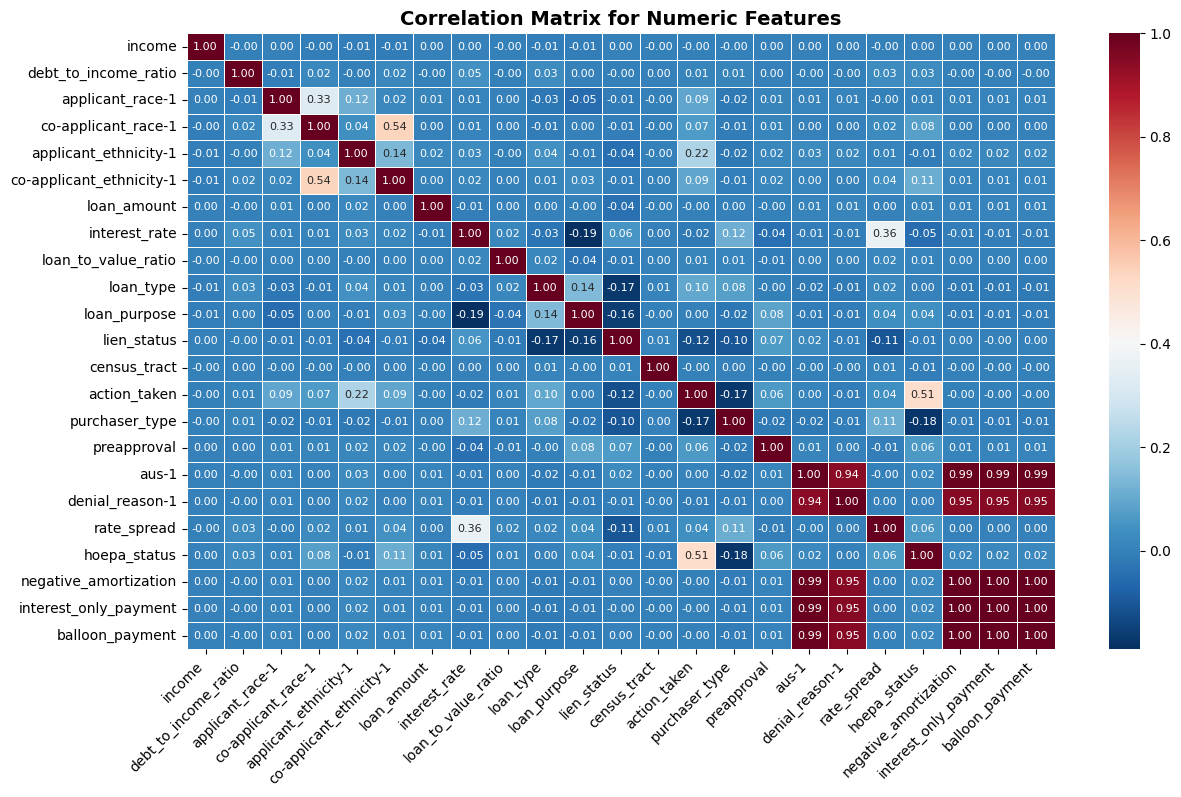

In [22]:
# Select only numeric columns from HDMA_filtered
HDMA_numeric = HDMA_filtered.select_dtypes(include=['number'])

# Set figure size for better readability
plt.figure(figsize=(14, 8))

# Generate heatmap with improved styling
sns.heatmap(
    HDMA_numeric.corr(),
    annot=True,
    cmap="RdBu_r",  # Alternative: "coolwarm", "viridis", "Blues"
    fmt=".2f",
    linewidths=0.7,
    annot_kws={"size": 8}  # Adjust annotation font size
)

# Improve axis labels
plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotate for readability
plt.yticks(fontsize=10)
plt.title("Correlation Matrix for Numeric Features", fontsize=14, fontweight="bold")

plt.show()


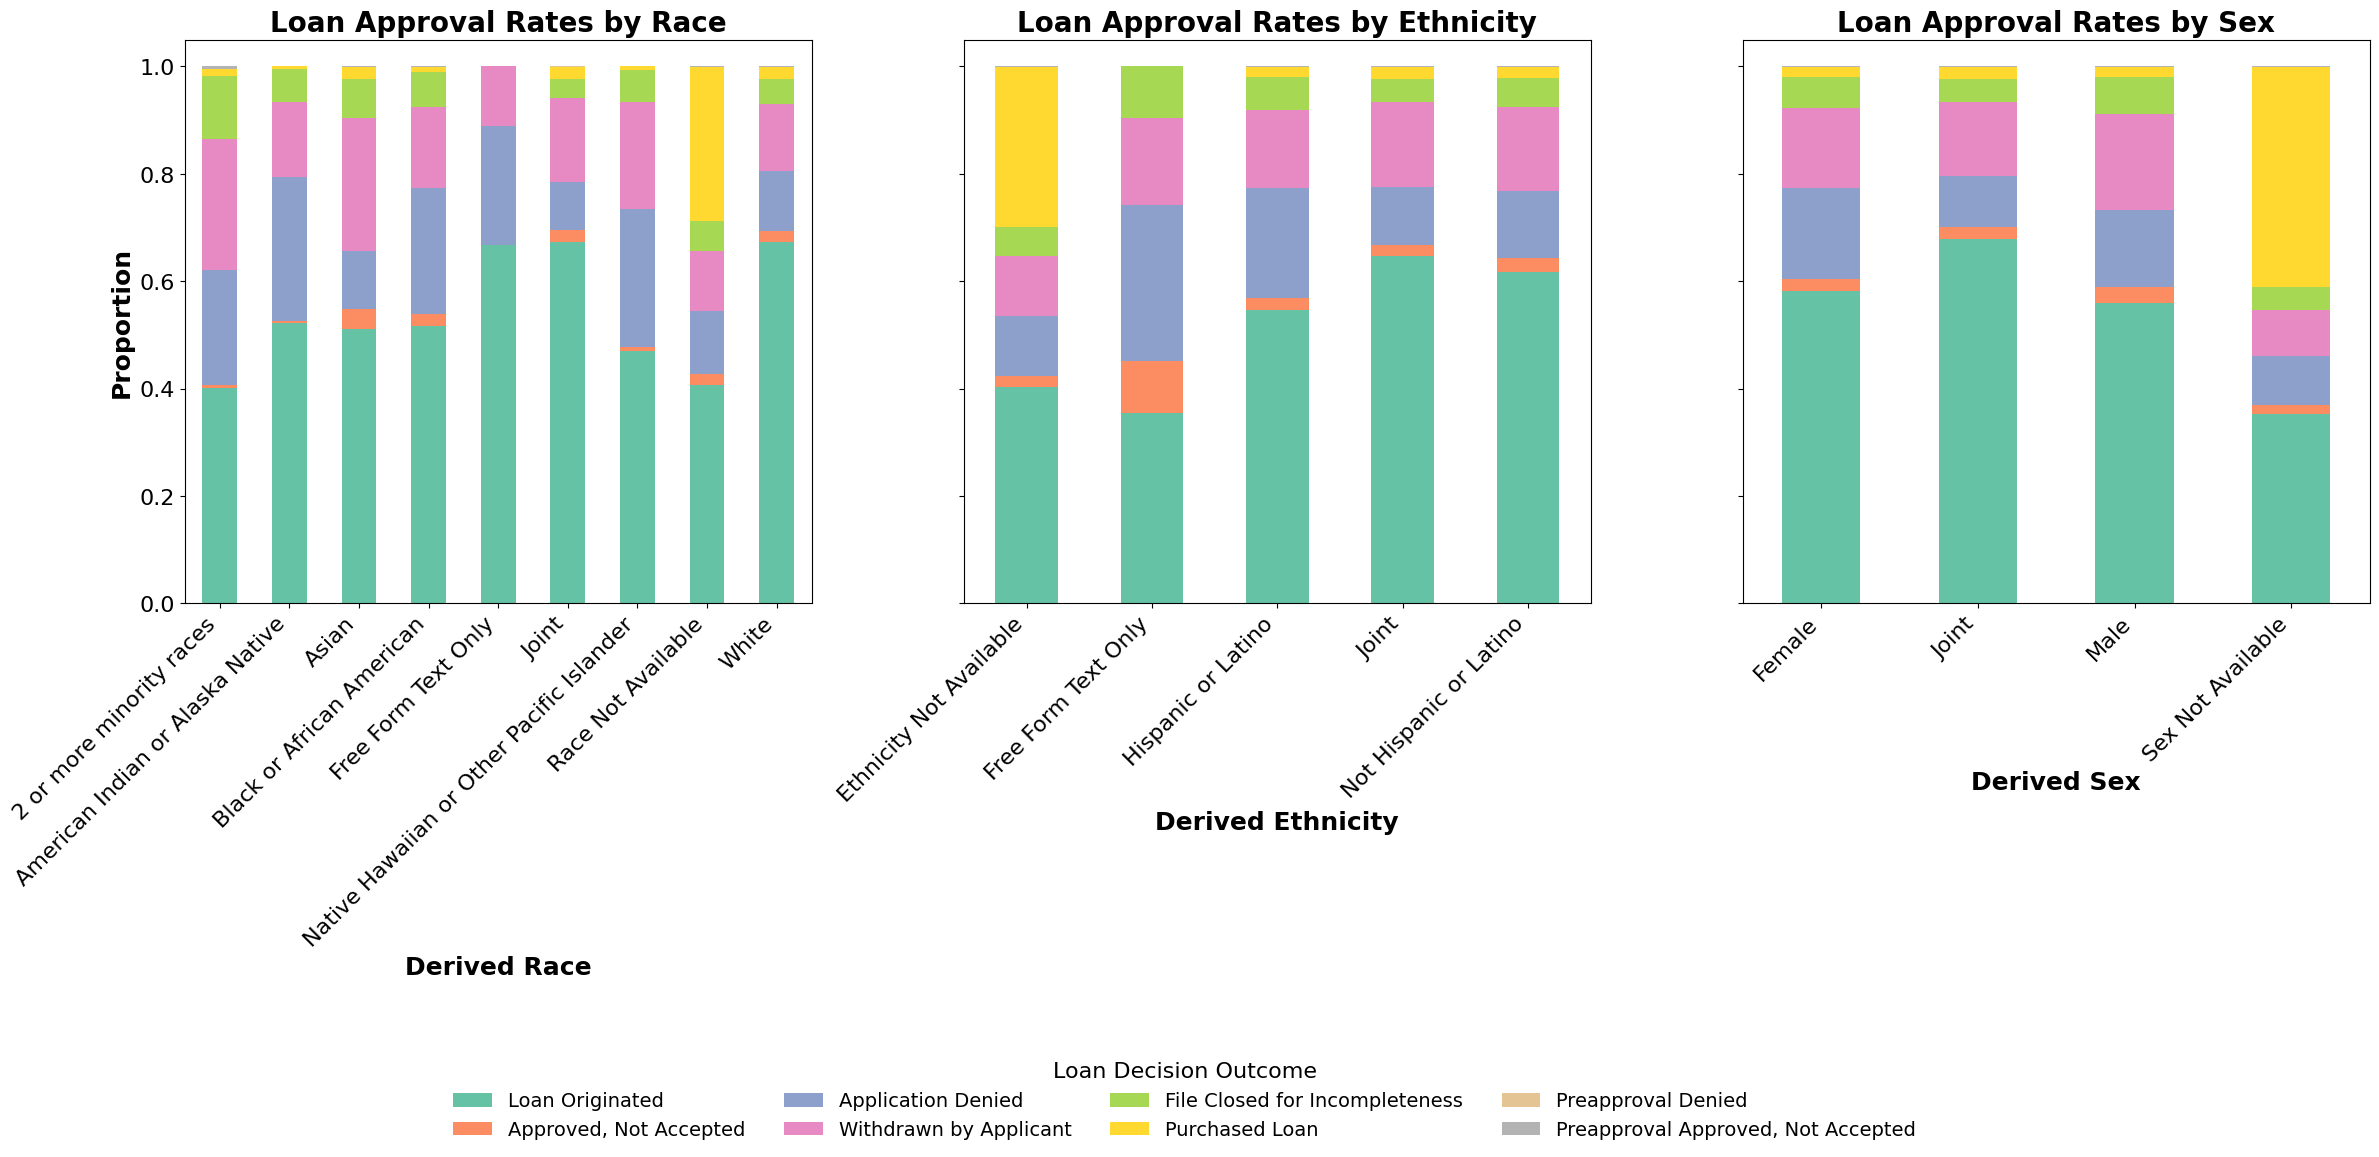

In [23]:
# Define the mapping of action_taken values to meaningful labels
action_labels = {
    1: "Loan Originated",
    2: "Approved, Not Accepted",
    3: "Application Denied",
    4: "Withdrawn by Applicant",
    5: "File Closed for Incompleteness",
    6: "Purchased Loan",
    7: "Preapproval Denied",
    8: "Preapproval Approved, Not Accepted"
}

# Increase figure size for better visibility
fig, axes = plt.subplots(1, 3, figsize=(24, 10), sharey=True)

# Define categorical columns and titles
categorical_cols = ['derived_race', 'derived_ethnicity', 'derived_sex']
titles = ['Loan Approval Rates by Race', 'Loan Approval Rates by Ethnicity', 'Loan Approval Rates by Sex']

# Loop through each category and create stacked bar plots
for ax, col, title in zip(axes, categorical_cols, titles):
    # Normalize value counts to get proportions
    grouped = HDMA_filtered.groupby(col)['action_taken'].value_counts(normalize=True).unstack()

    # Rename columns (action_taken values) to their descriptions
    grouped.columns = [action_labels.get(val, val) for val in grouped.columns]

    # Plot stacked bar chart without individual legends
    grouped.plot(kind='bar', stacked=True, ax=ax, colormap='Set2', legend=False)

    # Set title and labels
    ax.set_title(title, fontsize=20, fontweight='bold')
    ax.set_ylabel("Proportion", fontsize=18, fontweight='bold')
    ax.set_xlabel(col.replace("_", " ").title(), fontsize=18, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)
    ax.tick_params(axis='y', labelsize=16)

# Adjust layout for better spacing
plt.tight_layout()

# Remove legends from individual plots, but create one centralized legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Loan Decision Outcome", loc="upper center", bbox_to_anchor=(0.5, -0.05),
           ncol=4, frameon=False, fontsize=14, title_fontsize=16)

plt.show()


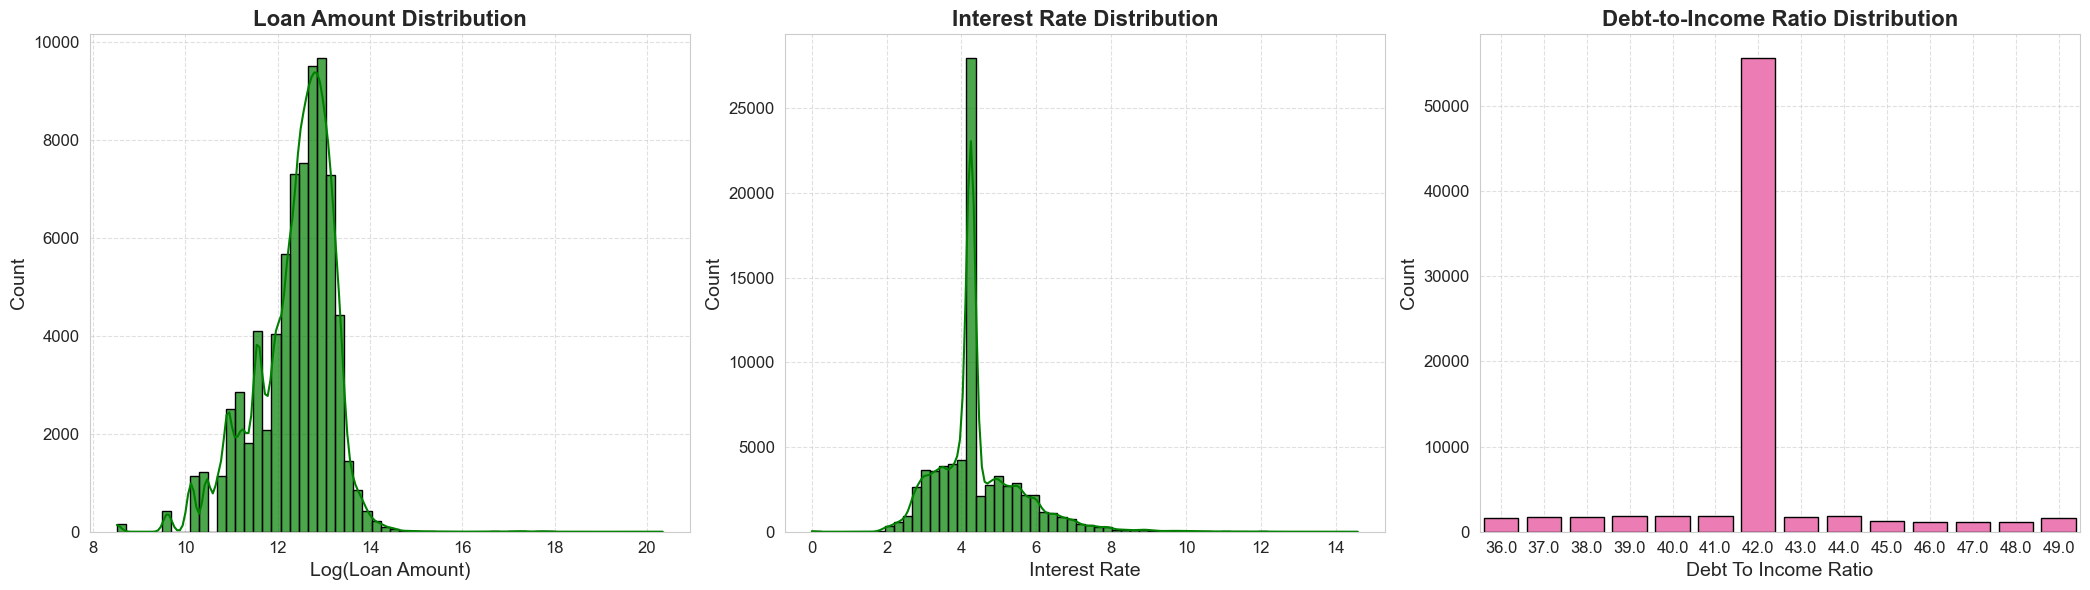

In [24]:
# Set overall style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Define key financial features and titles
features = ['loan_amount', 'interest_rate', 'debt_to_income_ratio']
titles = ['Loan Amount Distribution', 'Interest Rate Distribution', 'Debt-to-Income Ratio Distribution']

# Loop through each feature and create improved histograms
for ax, feature, title in zip(axes, features, titles):
    data = HDMA_filtered[feature]

    # Handle extreme skew in 'loan_amount' using log scale for better visualization
    if feature == 'loan_amount':
        data = np.log1p(data)  # Log transformation to spread out large values
        xlabel = "Log(Loan Amount)"
    else:
        xlabel = feature.replace("_", " ").title()

    # Use KDE only for continuous variables
    if feature == "debt_to_income_ratio":
        # Use bar plot for discrete variable
        dti_counts = data.value_counts().sort_index()
        sns.barplot(x=dti_counts.index, y=dti_counts.values, ax=ax, color="hotpink", edgecolor="black")
    else:
        # Histogram + KDE for continuous variables
        sns.histplot(data, bins=60, kde=True, ax=ax, color="green", alpha=0.7, edgecolor="black", linewidth=1, line_kws={"color": "black"})

    # Set titles and labels
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.tick_params(axis="both", labelsize=12)

    # Add gridlines for better readability
    ax.grid(True, linestyle="--", alpha=0.6)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


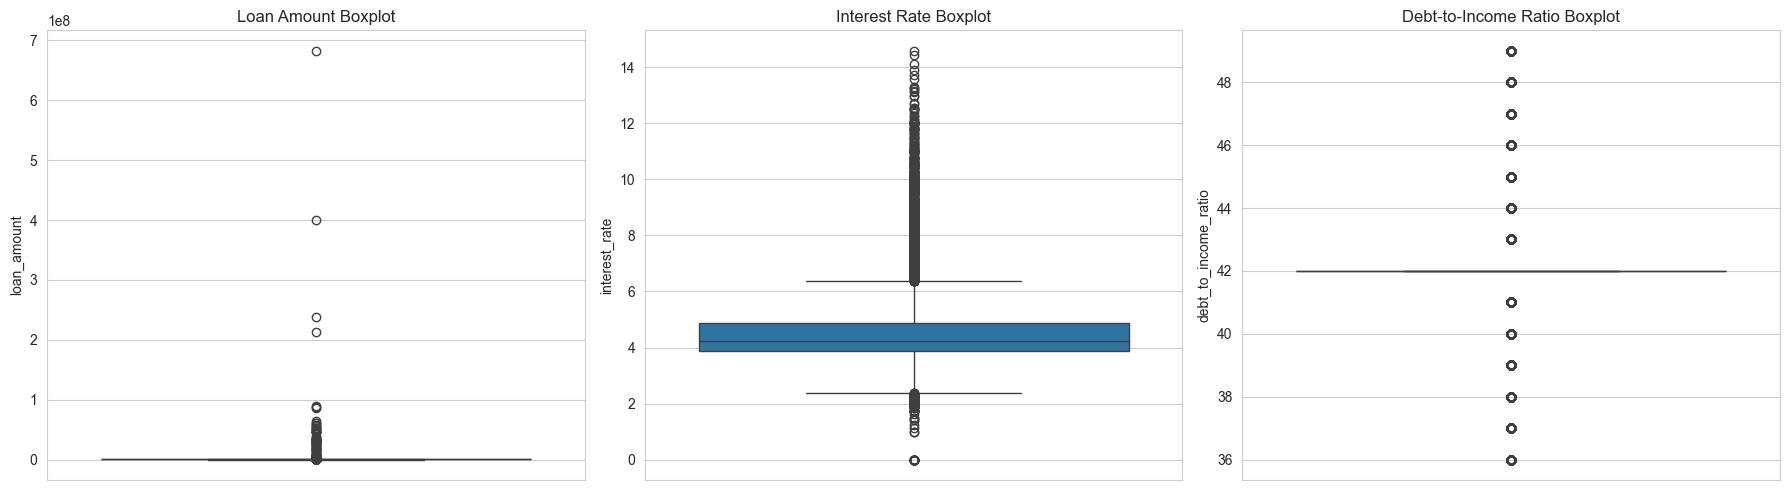

/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/dmeyer/Library/Python

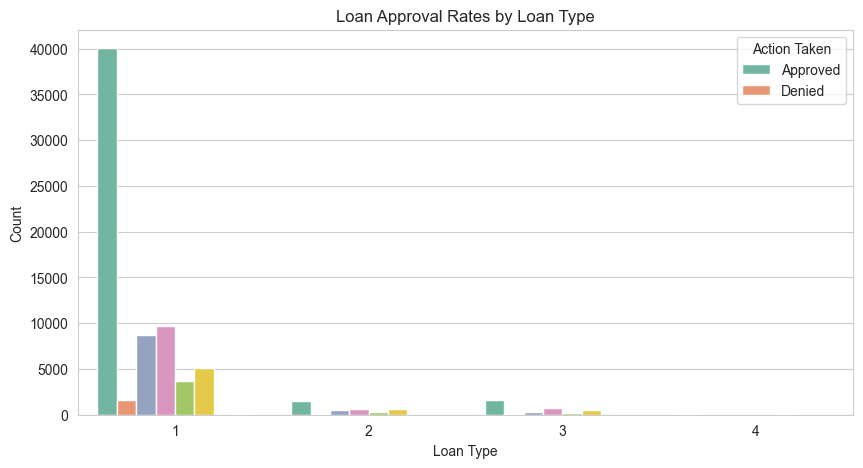

In [25]:
# Boxplots for outlier detection
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=HDMA_filtered['loan_amount'], ax=axes[0])
axes[0].set_title("Loan Amount Boxplot")

sns.boxplot(y=HDMA_filtered['interest_rate'], ax=axes[1])
axes[1].set_title("Interest Rate Boxplot")

sns.boxplot(y=HDMA_filtered['debt_to_income_ratio'], ax=axes[2])
axes[2].set_title("Debt-to-Income Ratio Boxplot")

plt.tight_layout()
plt.show()

# Loan Approval Rates by Loan Type
plt.figure(figsize=(10, 5))
sns.countplot(data=HDMA_filtered, x="loan_type", hue="action_taken", palette="Set2")
plt.title("Loan Approval Rates by Loan Type")
plt.xlabel("Loan Type")
plt.ylabel("Count")
plt.legend(title="Action Taken", labels=["Approved", "Denied"])
plt.show()

## **Building a random forest**

### 🎯 Target Variable Definition: `loan_approved`

In this analysis, our goal is to detect and mitigate **bias in lender decisions** — not applicant behavior. Therefore, we define our target variable `loan_approved` by focusing only on outcomes where the **lender made an approval or denial decision**.

#### ✅ We consider the following `action_taken` codes as **lender approvals**:
- `1`: Loan originated  
- `2`: Application approved but not accepted  
- `8`: Preapproval request approved but not accepted  

These reflect cases where the **lender said yes**, regardless of whether the applicant accepted the offer.

#### ❌ We consider the following `action_taken` codes as **lender denials**:
- `3`: Application denied  
- `7`: Preapproval request denied  

These represent direct **denial decisions made by the lender**.

#### 🚫 We **exclude** the following outcomes from our analysis:
- `4`: Application withdrawn by applicant (customer’s choice)  
- `5`: File closed for incompleteness (possibly missing documents)  
- `6`: Purchased loan (no approval decision was made)

These cases do not reflect clear lender intent, so including them could distort our fairness analysis.

**I used a different variable name for each step - for easy debugging**

In [26]:
# STEP 1: Make a copy of the filtered HMDA data
rf_model_data_1 = HDMA_filtered.copy()

# STEP 2: Filter dataset to include only lender decisions (remove irrelevant action_taken values)
rf_model_data_2 = rf_model_data_1[rf_model_data_1['action_taken'].isin([1, 2, 3, 7, 8])]

# STEP 3: Define target variable: 1 = approved, 0 = denied
rf_model_data_3 = rf_model_data_2.copy()
rf_model_data_3['loan_approved'] = rf_model_data_3['action_taken'].isin([1, 2, 8]).astype(int)

# Show the first few rows to verify changes
# rf_model_data_3.head()

In [27]:
rf_model_data_3['loan_approved'].value_counts()

loan_approved
1    45070
0     9608
Name: count, dtype: int64

In [28]:
# Step 4: Define the features we want to use for prediction
selected_features = [
    'derived_race', 'derived_ethnicity', 'derived_sex',
    'applicant_age', 'income',
    'loan_amount', 'interest_rate', 'loan_purpose', 'loan_type', 'debt_to_income_ratio'
]

# Step 5: Keep only selected features + target variable
rf_model_data_4 = rf_model_data_3[selected_features + ['loan_approved']].copy()

# Step 6: Convert age to string since it's in range format like '35-44'
rf_model_data_4['applicant_age'] = rf_model_data_4['applicant_age'].astype(str)

In [29]:
# Replace numeric codes with descriptions for loan_purpose
rf_model_data_4['loan_purpose'] = rf_model_data_4['loan_purpose'].replace({
    1: 'Home purchase',
    2: 'Home improvement',
    31: 'Refinancing',
    32: 'Cash-out refinancing',
    4: 'Other purpose',
    5: 'Not applicable'
})

# Replace numeric codes with descriptions for loan_type
rf_model_data_4['loan_type'] = rf_model_data_4['loan_type'].replace({
    1: 'Conventional',
    2: 'FHA',
    3: 'VA',
    4: 'RHS or FSA'
})

In [30]:
# Step 7: One-hot encode only the categorical features among selected ones
rf_model_data_5 = pd.get_dummies(
    rf_model_data_4,
    columns=['derived_race', 'derived_ethnicity', 'derived_sex', 'applicant_age', 'loan_purpose', 'loan_type'],
    drop_first=True
)

In [31]:
#rf_model_data_5.head()

In [32]:
# Step 8: Separate features (X) from the target variable (y)
X = rf_model_data_5.drop('loan_approved', axis=1)
y = rf_model_data_5['loan_approved']

In [33]:
# Step 9: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 20% for testing
    stratify=y,             # preserves the proportion of 1s and 0s in both sets
    random_state=42         # ensures reproducibility
)

In [34]:
# Step 10: Train the Random Forest model on the training set
# Initialize the model with 100 trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
# Step 11: Make predictions on the test set
# Use the trained model to predict loan approvals
y_pred = rf_model.predict(X_test)

In [36]:
# Step 12: Evaluate model performance
# Print core evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# Show classification report with F1-score
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Show confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9693672275054864
Precision: 0.9882975132215596
Recall: 0.9743731972487242

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      1922
           1       0.99      0.97      0.98      9014

    accuracy                           0.97     10936
   macro avg       0.94      0.96      0.95     10936
weighted avg       0.97      0.97      0.97     10936

Confusion Matrix:
 [[1818  104]
 [ 231 8783]]


 ### **Model Evaluation Summary**

After training the Random Forest model to predict whether a home loan will be approved (`loan_approved = 1`) or denied (`loan_approved = 0`), we evaluated it using a test set of **10,936** records. Below is a detailed explanation of the model's performance.

---

### **Overall Accuracy: 96.99%**
Out of all the test samples, **96.99%** of the predictions made by the model were correct.

The model is performing very well overall.

---

###  **Class Breakdown**

#### **Class 0 — Denied Loans**
| Metric     | Value | Interpretation                                                  |
|------------|-------|------------------------------------------------------------------|
| Precision  | 0.89  | When the model predicts a loan is denied, it's correct 89% of the time. |
| Recall     | 0.95  | The model correctly identifies 95% of all denied loans.          |
| F1-Score   | 0.92  | A balanced score combining precision and recall.                |

#### **Class 1 — Approved Loans**
| Metric     | Value | Interpretation                                                   |
|------------|-------|-------------------------------------------------------------------|
| Precision  | 0.99  | When the model predicts a loan is approved, it's correct 99% of the time. |
| Recall     | 0.97  | The model correctly identifies 97% of all approved loans.         |
| F1-Score   | 0.98  | Excellent balance between precision and recall.                   |

---

### **Confusion Matrix Explanation**

|                  | Predicted Denied | Predicted Approved |
|------------------|------------------|---------------------|
| **Actual Denied** (0) | 1825 ✅ (correct) | 97 ❌ (mistakenly approved) |
| **Actual Approved** (1) | 232 ❌ (mistakenly denied) | 8782 ✅ (correct) |

The model:
- Correctly predicted **1825** denied loans
- Incorrectly approved **97** denied loans
- Incorrectly denied **232** approved loans
- Correctly predicted **8782** approved loans

#### **Next, we try to find the features that are important**

/var/folders/2c/syyg1pks1tn35zqcqdf1629m0000gn/T/ipykernel_37223/1512381910.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='plasma')
/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gr

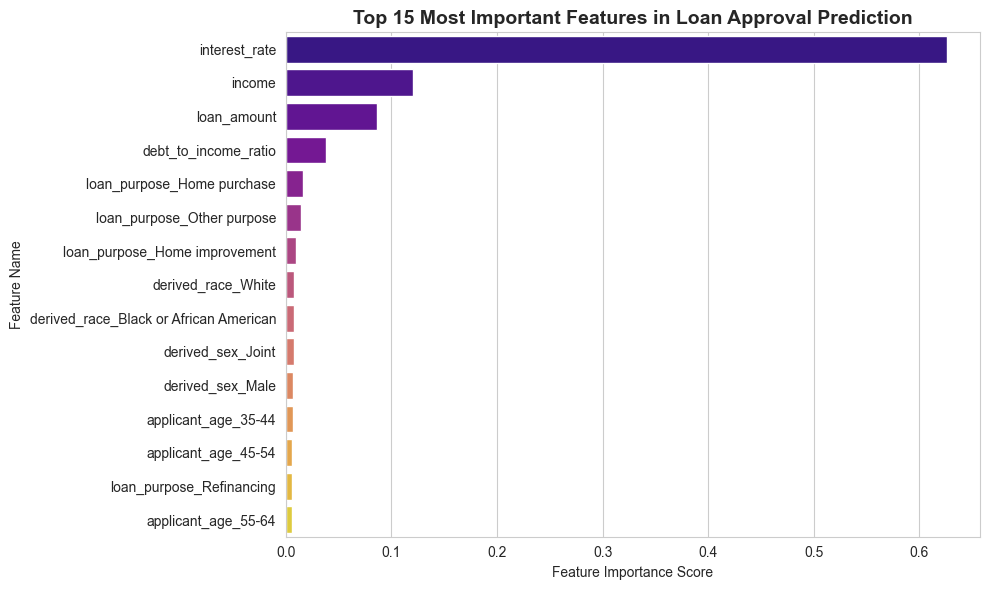

In [37]:
# Step 13: Visualize Feature Importance from the Random Forest model
# Get feature importances and sort them
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='plasma')
plt.title("Top 15 Most Important Features in Loan Approval Prediction", fontsize=14, weight='bold')
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

### **Why Is Interest Rate the Most Important Feature?**

At first, it seems strange that interest rate influences loan approval, since lenders set it.  
However, the model identified strong patterns linking high interest rates with higher denial rates.

This is likely because:
1. **Lenders still have risk limits** – Even with high rates, some applicants are **too risky** to approve.
2. **Regulations restrict extremely high interest loans** – Loans above a certain rate can be flagged as **"high-cost"** and denied.
3. **Affordability thresholds matter** – A high interest rate can push **monthly payments too high**, failing debt-to-income (DTI) requirements.

4. **Interest rate acts as a proxy for credit risk** – Since the dataset does not include FICO scores or credit history, the model may be using interest rate as a **stand-in for the borrower’s financial credibility** and risk level.

### **Other Important Features**

Besides interest rate, the model ranked these features as next most important:

- **Income** – Higher income signals better repayment ability → more likely to be approved.
- **Loan Amount** – Larger loan requests may be riskier → more likely to be denied.
- **Debt-to-Income Ratio** – High DTI = financial strain → lower chance of approval.
- **Loan Purpose: Home Purchase** – Home purchase loans are typically safer → more likely to be approved.



### **Detecting Bias in Loan Approvals**

To evaluate fairness in our model, we begin with a **disparity analysis**:

We compare **loan denial rates** across key demographic groups — including **race**, **ethnicity**, and **sex** — to identify any **inequities** in outcomes.

If certain groups consistently receive **higher denial rates**, this may signal potential **bias** in the data or model, even if unintentional.

This step is essential for ensuring that our model doesn't simply perform well — it also performs **fairly**.

In [38]:
# Use the original data with demographic info
bias_df = rf_model_data_3.copy()

# Calculate denial rates by race, ethnicity, and sex (as percentages)
denial_by_race = (1 - bias_df.groupby('derived_race')['loan_approved'].mean()) * 100
denial_by_ethnicity = (1 - bias_df.groupby('derived_ethnicity')['loan_approved'].mean()) * 100
denial_by_sex = (1 - bias_df.groupby('derived_sex')['loan_approved'].mean()) * 100

# Round to 2 decimal places for cleaner output
denial_by_race = denial_by_race.sort_values(ascending=False).round(2)
denial_by_ethnicity = denial_by_ethnicity.sort_values(ascending=False).round(2)
denial_by_sex = denial_by_sex.sort_values(ascending=False).round(2)

# Display
print("❌ Denial Rate by Race (%):\n", denial_by_race, "\n")
print("❌ Denial Rate by Ethnicity (%):\n", denial_by_ethnicity, "\n")
print("❌ Denial Rate by Sex (%):\n", denial_by_sex)


❌ Denial Rate by Race (%):
 derived_race
Native Hawaiian or Other Pacific Islander    35.00
2 or more minority races                     34.23
American Indian or Alaska Native             33.70
Black or African American                    30.30
Free Form Text Only                          25.00
Race Not Available                           21.34
Asian                                        16.36
White                                        13.81
Joint                                        11.65
Name: loan_approved, dtype: float64 

❌ Denial Rate by Ethnicity (%):
 derived_ethnicity
Free Form Text Only        39.13
Hispanic or Latino         26.57
Ethnicity Not Available    20.81
Not Hispanic or Latino     16.38
Joint                      13.87
Name: loan_approved, dtype: float64 

❌ Denial Rate by Sex (%):
 derived_sex
Female               22.01
Sex Not Available    19.74
Male                 19.68
Joint                11.99
Name: loan_approved, dtype: float64


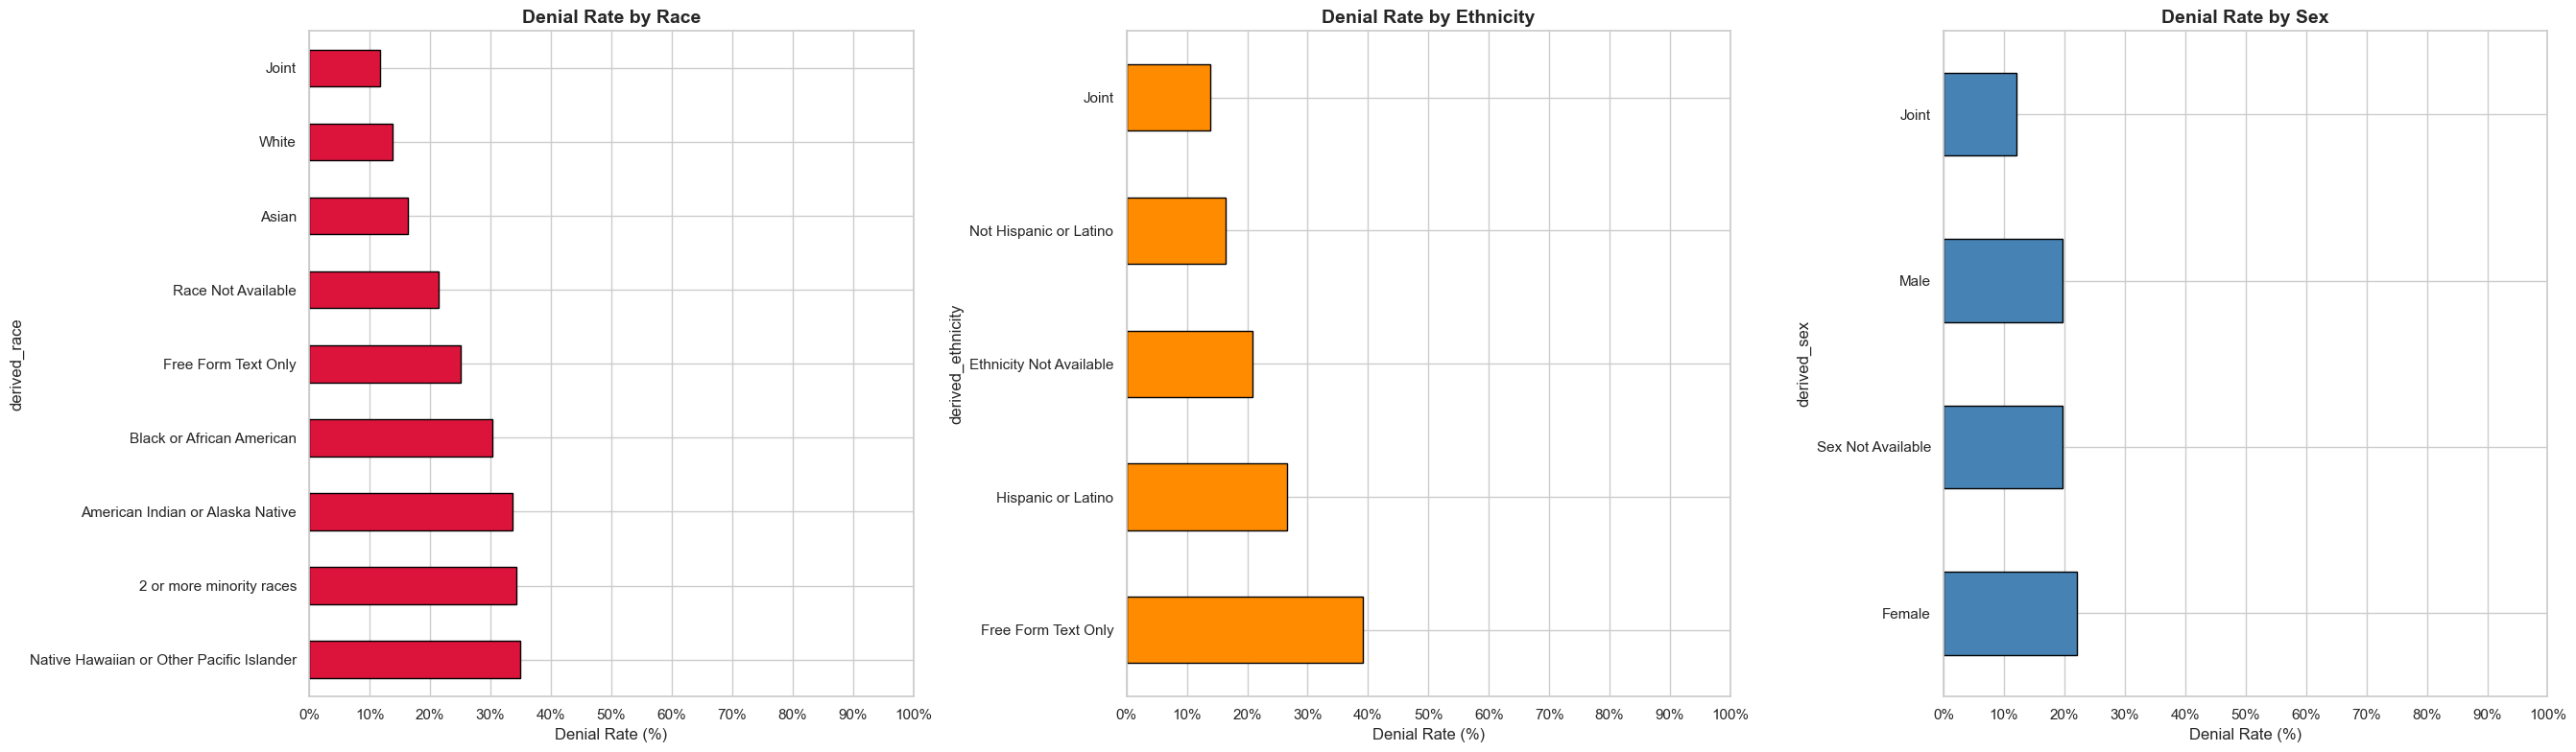

In [39]:
import matplotlib.ticker as mtick  # For percentage formatting

# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(27, 8))

# Plot 1: Race
denial_by_race.plot(kind='barh', ax=axes[0], color='crimson', edgecolor='black')
axes[0].set_title('Denial Rate by Race', fontsize=14, weight='bold')
axes[0].set_xlabel('Denial Rate (%)')
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[0].set_xlim(0, 100)
axes[0].set_xticks(range(0, 101, 10))

# Plot 2: Ethnicity
denial_by_ethnicity.plot(kind='barh', ax=axes[1], color='darkorange', edgecolor='black')
axes[1].set_title('Denial Rate by Ethnicity', fontsize=14, weight='bold')
axes[1].set_xlabel('Denial Rate (%)')
axes[1].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[1].set_xlim(0, 100)
axes[1].set_xticks(range(0, 101, 10))

# Plot 3: Sex
denial_by_sex.plot(kind='barh', ax=axes[2], color='steelblue', edgecolor='black')
axes[2].set_title('Denial Rate by Sex', fontsize=14, weight='bold')
axes[2].set_xlabel('Denial Rate (%)')
axes[2].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[2].set_xlim(0, 100)
axes[2].set_xticks(range(0, 101, 10))

# Tight layout
plt.tight_layout()
plt.show()

### **Disparity in Loan Denial Rates**

We compared loan denial rates across **race**, **ethnicity**, and **sex** to uncover possible signs of bias.

#### **By Race**:
- **White applicants:** 13.8% denied  
- **Black or African American applicants:** 30.3% denied  
- **Asian applicants:** 16.4% denied  
- **American Indian or Alaska Native:** 33.7% denied  
- **Pacific Islander:** 35.0% denied

**Notable Gap:** Black and Indigenous applicants face **denial rates more than twice as high** as White applicants — a concerning disparity that points toward possible systemic bias.

---

#### **By Ethnicity:**
- **Not Hispanic or Latino:** 16.4% denied  
- **Hispanic or Latino:** 26.6% denied  
- **Free Form Text Only:** 39.1% denied

**Notable Gap:** Hispanic applicants are denied loans **10 percentage points more often** than Non-Hispanic applicants.

---

#### **By Sex:**
- **Male:** 19.7% denied  
- **Female:** 22.1% denied  
- **Joint applicants:** 12.0% denied

**Notable Gap:** Female applicants are denied loans at a **slightly higher rate** than male applicants, while joint applications see the **lowest denial rates**.

---

There appears to be consistent/systemic gaps in denial rates across race and ethnicity. While some of this may reflect financial risk factors like income or debt, the **size and consistency** of these gaps strongly suggest that bias in decision-making may be playing a role.

## **What does this mean in terms of numbers and our actual dataset?**

In [40]:
# Helper function: group size and actual denials only
def actual_denials_summary(group_col):
    group_counts = bias_df[group_col].value_counts()
    denials = bias_df[bias_df['loan_approved'] == 0][group_col].value_counts()

    summary = pd.DataFrame({
        'Group Size': group_counts,
        'Actual Denials': denials
    }).fillna(0).astype(int)

    return summary

# Generate summary tables
race_summary = actual_denials_summary('derived_race')
ethnicity_summary = actual_denials_summary('derived_ethnicity')
sex_summary = actual_denials_summary('derived_sex')

# Display
print("📊 Actual Denials by Race:\n", race_summary, "\n")
print("📊 Actual Denials by Ethnicity:\n", ethnicity_summary, "\n")
print("📊 Actual Denials by Sex:\n", sex_summary)


📊 Actual Denials by Race:
                                            Group Size  Actual Denials
derived_race                                                         
2 or more minority races                          111              38
American Indian or Alaska Native                  181              61
Asian                                            7774            1272
Black or African American                        6584            1995
Free Form Text Only                                 8               2
Joint                                            1082             126
Native Hawaiian or Other Pacific Islander         100              35
Race Not Available                               9523            2032
White                                           29315            4047 

📊 Actual Denials by Ethnicity:
                          Group Size  Actual Denials
derived_ethnicity                                  
Not Hispanic or Latino        41991            6879
Ethnicity Not

### **Actual Denials by Group**

We examined **loan denials across race, ethnicity, and sex**, not just as percentages but as raw counts — to see the **real-world impact** on each group.

---

### 🧩 **Denials by Race**

| **Race Group**                          | **Group Size** | **Denied** | **What It Means** |
|----------------------------------------|----------------|------------|--------------------|
| **White**                              | 29,315         | 4,047      | ~1 in 7 were denied. |
| **Black or African American**          | 6,584          | 1,995      | ~1 in 3 were denied — a much **higher rate**. |
| **Asian**                              | 7,774          | 1,272      | More denials than expected for group size. |
| **American Indian or Alaska Native**   | 181            | 61         | High % denied despite small size. |
| **Joint**                               | 1,082          | 126        | Fewer denials; likely due to dual incomes. |
| **Native Hawaiian or Pacific Islander**| 100            | 35         | One-third of this small group denied. |
| **Race Not Available**                 | 9,523          | 2,032      | Can't analyze intent, but large count. |
| **2 or more minority races**           | 111            | 38         | High percentage denied. |
| **Free Form Text Only**                | 8              | 2          | Too small to interpret. |

** Key Insight**: Even though White applicants are the largest group, **Black, Native, and Pacific Islander applicants face disproportionately high denials relative to their size**.

---

### 🧩 **Denials by Ethnicity**

| **Ethnicity**               | **Group Size** | **Denied** |
|-----------------------------|----------------|------------|
| **Not Hispanic or Latino** | 41,991         | 6,879      |
| **Hispanic or Latino**     | 2,668          | 709        |
| **Ethnicity Not Available**| 9,001          | 1,873      |
| **Joint**                  | 995            | 138        |
| **Free Form Text Only**    | 23             | 9          |

** Key Insight**: Although a smaller group, **Hispanic applicants were denied at a noticeably higher rate** than Non-Hispanic applicants.

---

### 🧩 **Denials by Sex**

| **Sex**                | **Group Size** | **Denied** |
|------------------------|----------------|------------|
| **Male**               | 18,734         | 3,687      |
| **Female**             | 11,783         | 2,593      |
| **Joint**              | 18,604         | 2,231      |
| **Sex Not Available**  | 5,557          | 1,097      |


**Key Insight: Joint applicants** (e.g. couples) had the **lowest denial counts** despite a large group size. This suggests that **shared income/credit helps**.  
Individual applicants — especially females — were denied more frequently relative to their size.

---

###  **Why Does This Matter?**
These numbers make it clear:  
> **Bias isn't just a percentage — it's people.**  
By viewing actual counts, we see how many thousands of individuals are affected by systemic patterns in approval decisions.



In [41]:
print(HDMA_filtered['income'].describe())


count     76111.000000
mean        157.814258
std        1820.439438
min       -3090.000000
25%          84.000000
50%         123.000000
75%         175.000000
max      500000.000000
Name: income, dtype: float64


In [42]:
# Define income bins and labels (no changes to data)
bins = [-float('inf'), 0, 50, 100, 150, 200, 250, 300, 500, 1000, float('inf')]
labels = [
    '< 0',
    '1 - 50',
    '51 - 100',
    '101 - 150',
    '151 - 200',
    '201 - 250',
    '251 - 300',
    '301 - 500',
    '501 - 1000',
    '> 1000'
]

# Use pd.cut just temporarily (no column is added)
income_ranges = pd.cut(HDMA_filtered['income'], bins=bins, labels=labels)

# Count values in each range
income_distribution = income_ranges.value_counts().sort_index()

# Display the result
print(" Income Distribution:")
print(income_distribution)

 Income Distribution:
income
< 0             382
1 - 50         5676
51 - 100      19912
101 - 150     25132
151 - 200     10977
201 - 250      5917
251 - 300      3203
301 - 500      3671
501 - 1000      962
> 1000          279
Name: count, dtype: int64


In [43]:
# Step 1: Summary statistics
print("📊 Income Summary Statistics:")
print(HDMA_filtered['income'].describe())

# Step 2: Top 10 highest incomes
print("\n💰 Top 10 Highest Reported Incomes:")
print(HDMA_filtered['income'].sort_values(ascending=False).head(10))

📊 Income Summary Statistics:
count     76111.000000
mean        157.814258
std        1820.439438
min       -3090.000000
25%          84.000000
50%         123.000000
75%         175.000000
max      500000.000000
Name: income, dtype: float64

💰 Top 10 Highest Reported Incomes:
55736    500000.0
41324     12464.0
1144       9800.0
51221      9441.0
17888      9400.0
26472      7905.0
35378      7500.0
31972      7216.0
1616       7000.0
13992      6543.0
Name: income, dtype: float64


**Something is obviously wrong with the income distribution here.** Let us remove all the values less than zero.

In [44]:
# Make a copy of the original filtered dataset
feature_disparities_df = HDMA_filtered.copy()

# Remove rows where income is negative
feature_disparities_df = feature_disparities_df[feature_disparities_df['income'] >= 0]

# ✅ Confirm the change
print("Remaining rows after removing negative income values:", len(feature_disparities_df))
print("Minimum income now:", feature_disparities_df['income'].min())

Remaining rows after removing negative income values: 76066
Minimum income now: 0.0


In [45]:
print(feature_disparities_df['income'].describe())

count     76066.000000
mean        158.020154
std        1820.923690
min           0.000000
25%          85.000000
50%         123.000000
75%         175.000000
max      500000.000000
Name: income, dtype: float64


#  **Next Step – Investigating Feature Disparities**

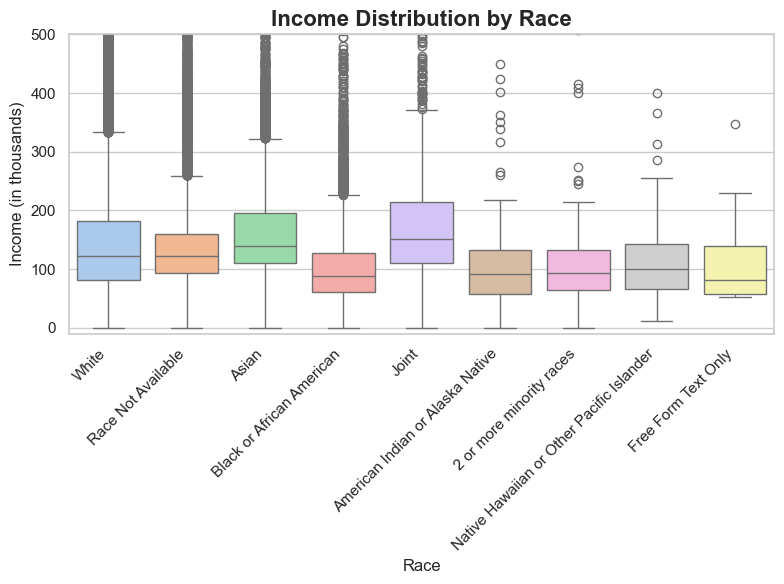

In [46]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Set plot style
sns.set(style="whitegrid")

# Create boxplot for income by race
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=feature_disparities_df,
    x='derived_race',
    y='income',
    order=feature_disparities_df['derived_race'].value_counts().index,
    palette='pastel'
)

# Custom y-axis to reflect most data
plt.ylim(-10, 500)

# Improve readability
plt.title("Income Distribution by Race", fontsize=16, weight='bold')
plt.xlabel("Race", fontsize=12)
plt.ylabel("Income (in thousands)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

## **Income Distribution by Race**

This boxplot helps us examine whether income levels vary across racial groups. Since income is a key factor in loan approval decisions, disparities here could explain or contribute to bias.

**Key Takeaways:**
- White, Asian, and Joint applicants show higher median incomes.
- Black or African American and American Indian applicants show lower medians.
- Outliers (dots above boxes) are common but were clipped for better visualization.

This confirms income gaps that could influence approval rates across groups.


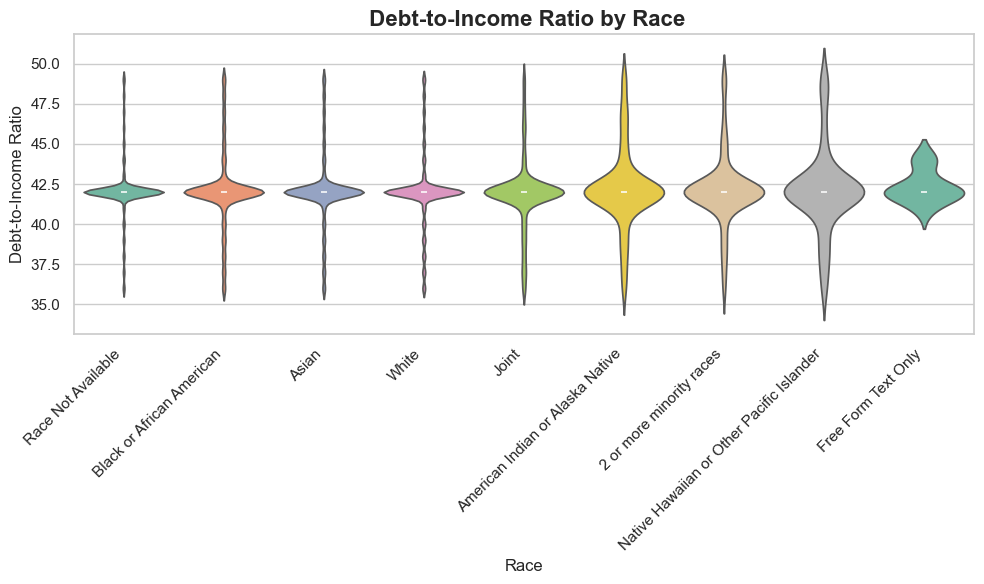

In [47]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set the style
sns.set(style="whitegrid")

# Create violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=feature_disparities_df,
    x='derived_race',
    y='debt_to_income_ratio',
    palette='Set2'
)

# Customize
plt.title(" Debt-to-Income Ratio by Race", fontsize=16, weight='bold')
plt.ylabel("Debt-to-Income Ratio")
plt.xlabel("Race")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **Debt-to-Income (DTI) Ratio by Race**

This violin plot explores the distribution of DTI ratios across racial groups. DTI helps assess how much debt an applicant carries relative to income — a key signal of repayment ability.

**Key Takeaways:**
- Most groups cluster around similar median DTI values.
- Some racial groups show wider distributions and longer tails, indicating more variability in financial stress.
- These subtle differences can affect loan decisions and contribute to systemic bias if not handled carefully in modeling.

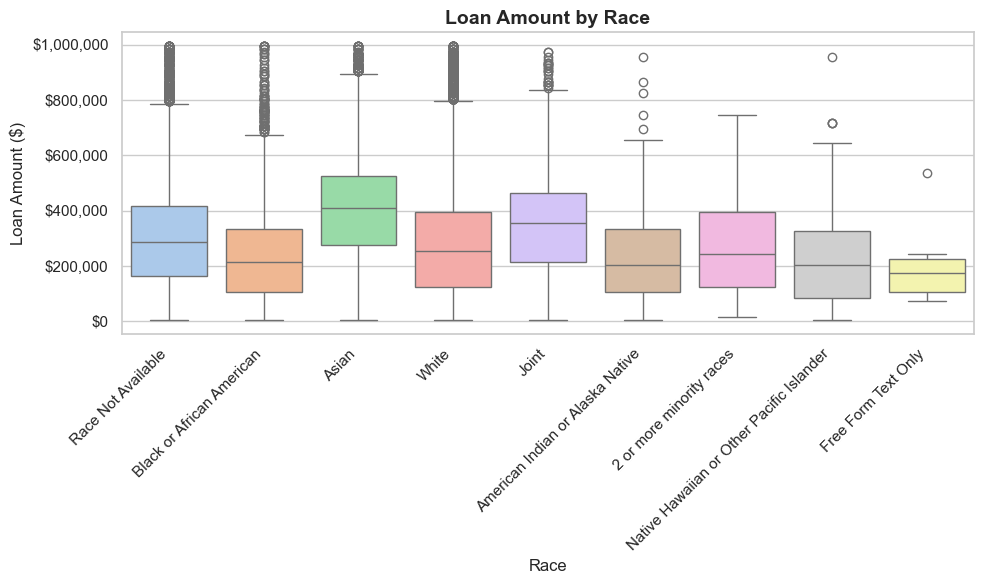

In [48]:
import matplotlib.ticker as mtick  # for dollar formatting

# Filter for reasonable loan amounts (under $1M)
loan_plot_df = feature_disparities_df[feature_disparities_df['loan_amount'] < 1_000_000]

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=loan_plot_df,
    x='derived_race',
    y='loan_amount',
    palette='pastel'
)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Format y-axis ticks as dollars
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Titles and labels
plt.title("Loan Amount by Race", fontsize=14, weight='bold')
plt.xlabel("Race")
plt.ylabel("Loan Amount ($)")
plt.tight_layout()
plt.show()


### **Loan Amount Distribution by Race**

This boxplot visualizes the distribution of **loan amounts (under $1M)** across racial groups, helping us spot differences in borrowing patterns or lender behavior.

**Why this matters:**
- Large loan amounts can increase default risk, but consistent differences across race could indicate access inequality.
- If certain groups receive smaller loans, even with similar qualifications, this may reflect discriminatory lending.

**Key Observations:**
- Median loan amounts differ across groups, with Asian and Joint applicants tending to request or receive higher loans.
- Several groups show wider spreads and higher upper ranges, suggesting variance in loan access or need.

We filtered out extreme outliers (loans above $1M) for a clearer comparison.


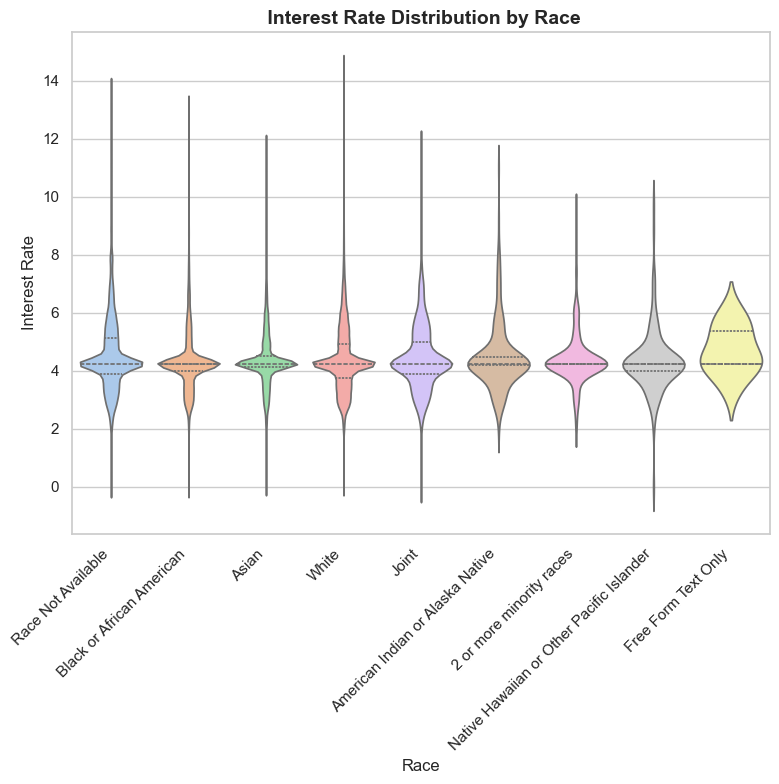

In [49]:
plt.figure(figsize=(8, 8))
sns.violinplot(
    data=feature_disparities_df,
    x='derived_race',
    y='interest_rate',
    palette='pastel',
    inner='quartile'
)
plt.xticks(rotation=45, ha='right')
plt.title(' Interest Rate Distribution by Race', fontsize=14, weight='bold')
plt.xlabel('Race')
plt.ylabel('Interest Rate')
plt.tight_layout()
plt.show()

### **Debt-to-Income (DTI) Ratio by Race**

This violin plot explores the distribution of DTI ratios across racial groups. DTI helps assess how much debt an applicant carries relative to income — a key signal of repayment ability.

**Key Takeaways:**
- Most groups cluster around similar median DTI values.
- Some racial groups show wider distributions and longer tails, indicating more variability in financial stress.
- These subtle differences can affect loan decisions and contribute to systemic bias if not handled carefully in modeling.

The violin plot gives a fuller picture of both spread and concentration compared to a boxplot.


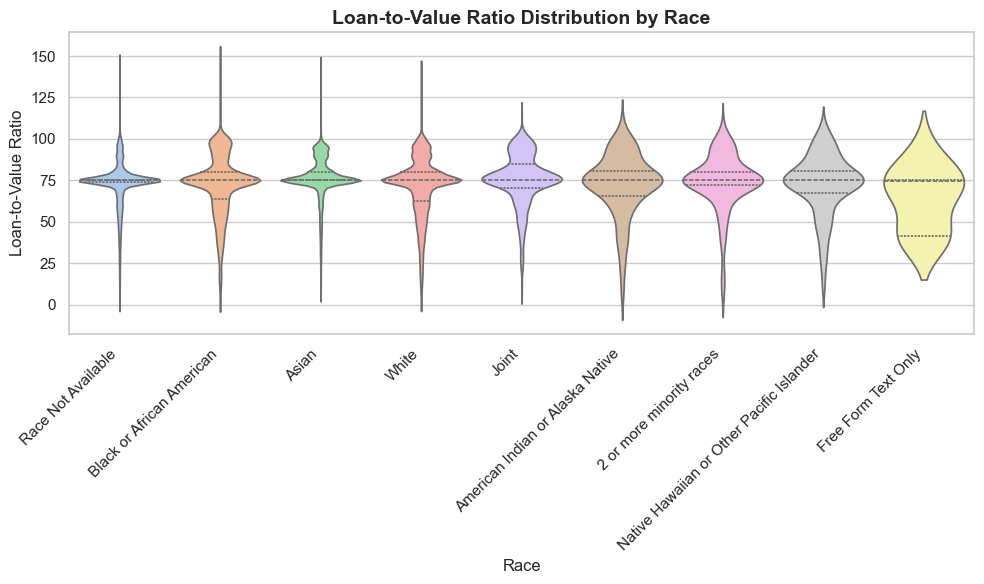

In [50]:
# Set style
sns.set(style="whitegrid")

# Filter to remove extreme outliers (e.g., LTV > 150)
ltv_plot_df = feature_disparities_df[feature_disparities_df['loan_to_value_ratio'] <= 150]

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=ltv_plot_df,
    x='derived_race',
    y='loan_to_value_ratio',
    palette='pastel',
    inner='quartile'
)

# Customize plot
plt.xticks(rotation=45, ha='right')
plt.title("Loan-to-Value Ratio Distribution by Race", fontsize=14, weight='bold')
plt.xlabel("Race")
plt.ylabel("Loan-to-Value Ratio")
plt.tight_layout()
plt.show()


### **Loan-to-Value Ratio by Race**

This plot shows how loan-to-value (LTV) ratios vary across racial groups. LTV tells us how much of the property’s value is being borrowed — higher values mean smaller down payments and more risk for the lender.

We removed extreme outliers (LTV > 150) so the main trends are easier to see. Most groups have LTV ratios around 75 to 80, but the shape of each group’s distribution shows how these ratios are spread out differently, which may reflect differences in financial flexibility or loan terms.


# **Disparate Impact Analysis for Race, Ethnicity and Sex**

In [51]:
# Step 1: Add predictions to the test set
X_test['predicted_approval'] = y_pred

# Step 2: Merge demographic attributes back for analysis
# (Make sure index is reset if needed)
demographics = rf_model_data_4.loc[X_test.index, ['derived_race', 'derived_ethnicity', 'derived_sex']].copy()
demographics['predicted_approval'] = y_pred
demographics['actual_approval'] = y_test.values

# Step 3: Function to compute disparate impact
def calculate_disparate_impact(df, group_col, privileged_group):
    """
    Returns the Disparate Impact ratio of unprivileged group to privileged group.
    """
    group_rates = df.groupby(group_col)['predicted_approval'].mean()
    di_ratios = group_rates / group_rates.get(privileged_group)
    return di_ratios.sort_values(ascending=True)

# Step 4: Apply it to Race, Ethnicity, and Sex
print("📊 Disparate Impact by Race:")
print(calculate_disparate_impact(demographics, 'derived_race', 'White'))

print("\n📊 Disparate Impact by Ethnicity:")
print(calculate_disparate_impact(demographics, 'derived_ethnicity', 'Not Hispanic or Latino'))

print("\n📊 Disparate Impact by Sex:")
print(calculate_disparate_impact(demographics, 'derived_sex', 'Male'))

📊 Disparate Impact by Race:
derived_race
American Indian or Alaska Native             0.755854
2 or more minority races                     0.766809
Free Form Text Only                          0.783849
Black or African American                    0.803854
Native Hawaiian or Other Pacific Islander    0.881830
Race Not Available                           0.908137
Asian                                        0.971324
White                                        1.000000
Joint                                        1.021212
Name: predicted_approval, dtype: float64

📊 Disparate Impact by Ethnicity:
derived_ethnicity
Hispanic or Latino         0.863632
Ethnicity Not Available    0.947206
Not Hispanic or Latino     1.000000
Joint                      1.050976
Free Form Text Only        1.212664
Name: predicted_approval, dtype: float64

📊 Disparate Impact by Sex:
derived_sex
Female               0.960793
Male                 1.000000
Sex Not Available    1.005091
Joint                1.093630

## **Building a Logistic Regression**

In [52]:
# Make a copy of the data
logreg_data = HDMA_filtered.copy()

In [53]:
# Check for Missing Values
#print(logreg_data.isnull().sum())

All values are accounted for. Now we need to check the data types

In [54]:
# Check the data types
# print(logreg_data.dtypes)

We have several different data types. Logistic regression requires numerical inputs. We will need to useing label encoding, ordinal encoding, and one hot encoding

In [55]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
logreg_data['derived_sex'] = label_enc.fit_transform(logreg_data['derived_sex'])
logreg_data['derived_ethnicity'] = label_enc.fit_transform(logreg_data['derived_ethnicity'])


In [56]:
from sklearn.preprocessing import OrdinalEncoder

# Map numeric values back to age categories
age_mapping = {
    0.0: '<25',
    1.0: '25-34',
    2.0: '35-44',
    3.0: '45-54',
    4.0: '55-64',
    5.0: '65-74',
    6.0: '>74'
}

logreg_data['applicant_age'] = logreg_data['applicant_age'].map(age_mapping)

# Handle missing values
logreg_data['applicant_age'].fillna('Unknown', inplace=True)  # Option 1: Replace NaNs with 'Unknown'
# logreg_data.dropna(subset=['applicant_age'], inplace=True)  # Option 2: Drop rows with NaNs

# Apply Ordinal Encoding
age_order = [['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74', 'Unknown']]
ord_enc = OrdinalEncoder(categories=age_order)

logreg_data[['applicant_age']] = ord_enc.fit_transform(logreg_data[['applicant_age']])


In [57]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse_output=False)  # Drop first category to prevent redundancy

categorical_cols = ['loan_type', 'loan_purpose', 'lien_status']  # Choose only key features
encoded_cols = encoder.fit_transform(logreg_data[categorical_cols])

logreg_data = logreg_data.drop(columns=categorical_cols)  # Drop original categorical columns
logreg_data[encoder.get_feature_names_out(categorical_cols)] = encoded_cols  # Add back encoded data


In [58]:
# When I was running the code, for some reason the lei was creating hundreds of rows.
# Dont think it is essential so just removed it.

logreg_data = logreg_data.loc[:, ~logreg_data.columns.str.startswith('lei')]

In [59]:
logreg_data = pd.get_dummies(logreg_data,
                             columns=['derived_race', 'conforming_loan_limit',
                                      'derived_loan_product_type', 'derived_dwelling_category'],
                             drop_first=True)

In [60]:
#print(np.isinf(logreg_data).sum())
#print((logreg_data > 1e10).sum())

In [61]:
# For some reason census_tract has a lot of missing values, so we are going to remove that
logreg_data = logreg_data.drop(columns=['census_tract'])

In [62]:
# Define lender approval (1) and denial (0) cases
approved_codes = {1, 2, 8}
denied_codes = {3, 7}

# Filter dataset to only include lender decisions
filtered_data = logreg_data[logreg_data['action_taken'].isin(approved_codes | denied_codes)].copy()

# Create target variable (loan_approved)
filtered_data['loan_approved'] = filtered_data['action_taken'].apply(lambda x: 1 if x in approved_codes else 0)

# Drop original action_taken column
filtered_data.drop(columns=['action_taken'], inplace=True)

X_lr = filtered_data.drop(columns=['loan_approved'])  # Features
y_lr = filtered_data['loan_approved']  # Target


In [63]:
from sklearn.model_selection import train_test_split

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)

In [64]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=5000, solver='lbfgs')
logreg.fit(X_train_lr, y_train_lr)

LogisticRegression(max_iter=5000)

In [65]:
from sklearn.metrics import accuracy_score

y_pred_lr = logreg.predict(X_test_lr)
accuracy = accuracy_score(y_test_lr, y_pred_lr)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9559


In [66]:
X_lr

,derived_ethnicity,derived_sex,applicant_age,income,debt_to_income_ratio,applicant_race-1,co-applicant_race-1,applicant_ethnicity-1,co-applicant_ethnicity-1,loan_amount,...,conforming_loan_limit_NC,derived_loan_product_type_Conventional:Subordinate Lien,derived_loan_product_type_FHA:First Lien,derived_loan_product_type_FHA:Subordinate Lien,derived_loan_product_type_FSA/RHS:First Lien,derived_loan_product_type_FSA/RHS:Subordinate Lien,derived_loan_product_type_VA:First Lien,derived_dwelling_category_Multifamily:Site-Built,derived_dwelling_category_Single Family (1-4 Units):Manufactured,derived_dwelling_category_Single Family (1-4 Units):Site-Built
0,0,3,7.0,81.0,49.0,6.0,8.0,3.0,5.0,445000.0,...,False,False,False,False,False,False,False,False,False,True
1,4,0,7.0,94.0,40.0,3.0,8.0,2.0,5.0,255000.0,...,False,False,False,False,False,False,False,False,False,True
2,4,1,7.0,204.0,42.0,2.0,2.0,2.0,2.0,275000.0,...,False,False,False,False,False,False,False,False,False,True
3,2,2,7.0,195.0,42.0,5.0,8.0,1.0,5.0,55000.0,...,False,True,False,False,False,False,False,False,False,True
4,0,3,7.0,109.0,42.0,6.0,8.0,3.0,5.0,235000.0,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76106,0,1,7.0,145.0,42.0,6.0,6.0,3.0,3.0,255000.0,...,False,False,False,False,False,False,False,False,False,True
76107,4,2,7.0,237.0,42.0,5.0,5.0,2.0,2.0,405000.0,...,False,False,False,False,False,False,False,False,False,True
76108,0,3,7.0,95.0,39.0,6.0,8.0,3.0,5.0,315000.0,...,False,False,True,False,False,False,False,False,False,True
76109,0,3,7.0,138.0,42.0,6.0,6.0,3.0,3.0,385000.0,...,False,False,False,False,False,False,False,False,False,True


In [67]:
y_lr[:1000]

0       1
1       1
2       1
3       1
4       1
       ..
1482    1
1483    1
1484    1
1485    0
1486    0
Name: loan_approved, Length: 1000, dtype: int64

Reweighing with Random Forest

🎯 Accuracy (Original RF):  0.9694
🎯 Accuracy (Reweighed RF): 0.9702

✅ Loan Approval Rate (Original RF):  81.264%
✅ Loan Approval Rate (Reweighed RF): 80.944%

📊 Disparate Impact by Race (Original RF):
race_code
American Indian or Alaska Native             0.755854
2 or more minority races                     0.766809
Free Form Text Only                          0.783849
Black or African American                    0.803854
Native Hawaiian or Other Pacific Islander    0.881830
Race Not Available                           0.908137
Asian                                        0.971324
White                                        1.000000
Joint                                        1.021212
Name: predicted_approval, dtype: float64

Privileged groups:
  - White (encoded as 8)

Unprivileged groups:
  - Black or African American (encoded as 3)

📊 Disparate Impact by Race (Reweighed RF):
race_code
Free Form Text Only                          0.000000
Native Hawaiian or Other Pacific Islander

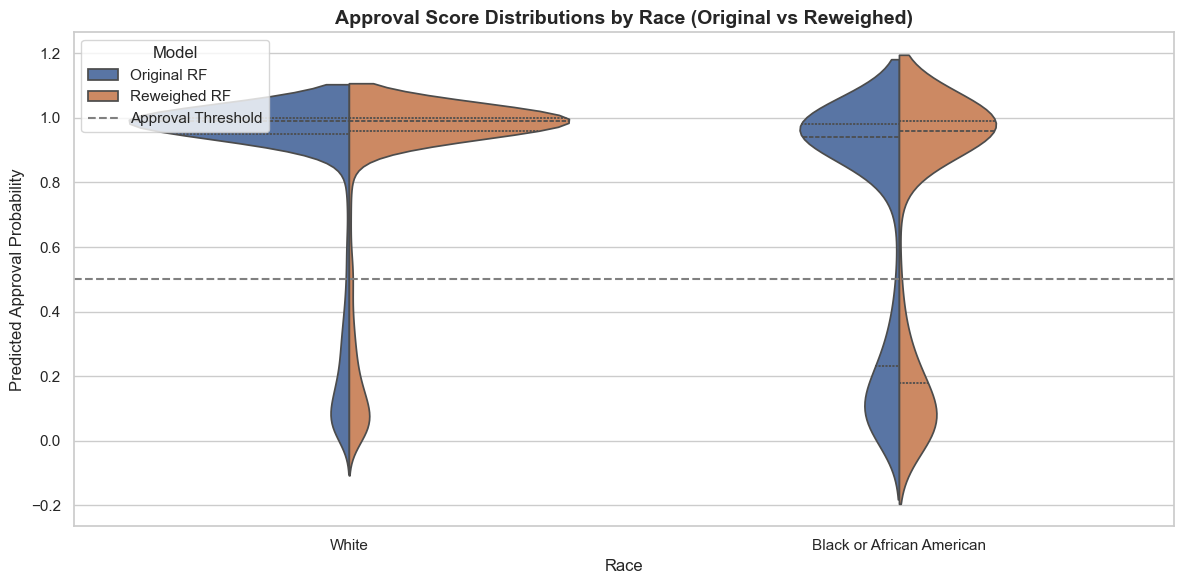

In [86]:
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import LabelEncoder


# ✅ Helper function to calculate Disparate Impact Ratio
def disparate_impact_ratio(df, group_col, outcome_col, privileged_val):
    """
    Returns the Disparate Impact ratio of unprivileged group to privileged group.
    - df: DataFrame with predictions and group labels
    - group_col: protected attribute (e.g., 'race_label')
    - outcome_col: binary outcome column (e.g., 'predicted')
    - privileged_val: label of the privileged group (e.g., 'White' or 4 if encoded)
    """
    rates = df.groupby(group_col)[outcome_col].mean()
    return (rates / rates[privileged_val]).sort_values()


# Step 1: Prepare data
aif_data = rf_model_data_4.copy()
aif_data['loan_approved'] = rf_model_data_3['loan_approved']

# Step 2: Encode protected attribute BEFORE one-hot encoding
aif_data['race_original'] = aif_data['derived_race']  # Keep for later analysis

# Encode `derived_race` as numeric (required for AIF360)
race_encoder = LabelEncoder()
aif_data['derived_race'] = race_encoder.fit_transform(aif_data['derived_race'])

# Step 3: One-hot encode all other categorical variables
X_encoded = pd.get_dummies(
    aif_data.drop(['loan_approved', 'race_original'], axis=1),  # Exclude label + saved race
    drop_first=True
)
y = aif_data['loan_approved'].values

# Step 4: Combine features, label, and encoded derived_race
X_encoded['loan_approved'] = y
X_encoded['derived_race'] = aif_data['derived_race'].values  # Add numeric race back in last

# Step 5: Build BinaryLabelDataset
dataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=X_encoded,
    label_names=['loan_approved'],
    protected_attribute_names=['derived_race']
)

# -------------------------------------------
# ✅ 3. Apply Reweighing
# -------------------------------------------
# Redefine privileged/unprivileged groups using numeric codes
# Get encoded values
race_classes = list(race_encoder.classes_)

# Define multiple privileged values
privileged_race_vals = [race_classes.index(r) for r in ['White']]
unprivileged_race_vals = [race_classes.index(r) for r in ['Black or African American']]

# Build AIF360 group structures
privileged = [{'derived_race': val} for val in privileged_race_vals]
unprivileged = [{'derived_race': val} for val in unprivileged_race_vals]


RW = Reweighing(unprivileged_groups=unprivileged,
                privileged_groups=privileged)
RW.fit(dataset)
reweighed_dataset = RW.transform(dataset)

# -------------------------------------------
# ✅ 4. Train-Test Split and Reweighting
# -------------------------------------------
from sklearn.model_selection import train_test_split

# Split using AIF360 API
train, test = dataset.split([0.8], shuffle=True)

# Reweighed training set
train_rw = RW.transform(train)

# Extract features and labels from AIF360 objects
X_train_rw = train_rw.features
y_train_rw = train_rw.labels.ravel()
sample_weights = train_rw.instance_weights

X_test_rw = test.features
y_test_rw = test.labels.ravel()

# -------------------------------------------
# ✅ 5. Random Forest on Reweighted Data
# -------------------------------------------
rf_rw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_rw.fit(X_train_rw, y_train_rw, sample_weight=sample_weights)

y_pred_rw = rf_rw.predict(X_test_rw)

# -------------------------------------------
# ✅ 6. Evaluation: Accuracy and Fairness
# -------------------------------------------

from sklearn.metrics import accuracy_score, classification_report

# ----------------------------------------------------------
# 🔁 1. Decode race labels (for human-readable output)
# ----------------------------------------------------------
race_label_map = dict(enumerate(race_encoder.classes_))  # {0: 'Asian', 1: 'Black...', ...}
white_index = list(race_encoder.classes_).index('White')

# ----------------------------------------------------------
# 📊 2. Build original model evaluation dataframe
# ----------------------------------------------------------
# Assuming demographics was built using original y_pred
demographics['race_code'] = race_encoder.transform(demographics['derived_race'])
demographics['race_label'] = demographics['race_code'].map(race_label_map)

# ----------------------------------------------------------
# 📊 3. Build reweighed model evaluation dataframe
# ----------------------------------------------------------
df_test = pd.DataFrame(X_test_rw, columns=dataset.feature_names)
df_test['race_code'] = test.protected_attributes.ravel().astype(int)
df_test['actual'] = y_test_rw
df_test['predicted'] = y_pred_rw
df_test['race_label'] = df_test['race_code'].map(race_label_map)

# ----------------------------------------------------------
# ✅ 4. Accuracy Comparison
# ----------------------------------------------------------
acc_original = accuracy_score(y_test, y_pred)
acc_reweighed = accuracy_score(y_test_rw, y_pred_rw)

print(f"🎯 Accuracy (Original RF):  {acc_original:.4f}")
print(f"🎯 Accuracy (Reweighed RF): {acc_reweighed:.4f}")

# ----------------------------------------------------------
# 📈 5. Approval Rate Comparison
# ----------------------------------------------------------
approval_rate_original = demographics['predicted_approval'].mean()
approval_rate_reweighed = df_test['predicted'].mean()

print(f"\n✅ Loan Approval Rate (Original RF):  {approval_rate_original:.3%}")
print(f"✅ Loan Approval Rate (Reweighed RF): {approval_rate_reweighed:.3%}")

# ----------------------------------------------------------
# ⚖️ 6. Disparate Impact (by Race)
# ----------------------------------------------------------
print("\n📊 Disparate Impact by Race (Original RF):")
print(disparate_impact_ratio(demographics, 'race_code', 'predicted_approval', white_index).rename(race_label_map))

print("\nPrivileged groups:")
for val in privileged_race_vals:
    print(f"  - {race_encoder.classes_[val]} (encoded as {val})")

print("\nUnprivileged groups:")
for val in unprivileged_race_vals:
    print(f"  - {race_encoder.classes_[val]} (encoded as {val})")

print("\n📊 Disparate Impact by Race (Reweighed RF):")
print(disparate_impact_ratio(df_test, 'race_code', 'predicted', white_index).rename(race_label_map))


# import matplotlib.pyplot as plt
# import seaborn as sns

# ----------------------------------------
# 🧪 Get predicted approval probabilities
# ----------------------------------------

# 🛠 Clean X_test to avoid sklearn feature mismatch error
X_test_original = X_test.drop(columns=['predicted_approval'], errors='ignore')

# Original model predicted probabilities
proba_original = rf_model.predict_proba(X_test_original)[:, 1]
demographics['approval_score'] = proba_original

# Reweighed model probabilities
proba_reweighed = rf_rw.predict_proba(X_test_rw)[:, 1]
df_test['approval_score'] = proba_reweighed

# ----------------------------------------
# 🎨 Visualize: Approval Score Distributions
# ----------------------------------------

# Combine into one DataFrame for plotting
plot_df = pd.concat([
    demographics[['race_label', 'approval_score']].assign(model='Original RF'),
    df_test[['race_label', 'approval_score']].assign(model='Reweighed RF')
])

# Filter to just key groups (e.g., White & Black) for clarity
plot_df = plot_df[plot_df['race_label'].isin(['White', 'Black or African American'])]

plt.figure(figsize=(12, 6))
sns.violinplot(data=plot_df, x='race_label', y='approval_score', hue='model', split=True, inner='quartile')
plt.axhline(0.5, color='gray', linestyle='--', label='Approval Threshold')
plt.title('Approval Score Distributions by Race (Original vs Reweighed)', fontsize=14, weight='bold')
plt.xlabel('Race')
plt.ylabel('Predicted Approval Probability')
plt.legend(title='Model', loc='upper left')
plt.tight_layout()
plt.show()
